# Fashion MNIST notebook

## import libraries

In [1]:
import os
# Set TensorFlow logging to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # This silences INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
tf.get_logger().setLevel('ERROR')

try:
  import pennylane as qml
except:
  !pip install pennylane
  import pennylane as qml
from pennylane.operation import Operation

2024-10-22 22:51:26.812930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 22:51:26.842781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 22:51:26.851847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Import the dataset

In [2]:
# set random seed
random = 10 

In [3]:
# Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly
import tensorflow as tf
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Filter for only the classes 0 and 3
train_filter = np.where((y_train == 0) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

## Use the first 500 images as the training set
x_train, y_train = x_train[:12000], y_train[:12000]
# Randomly sample 300 images from the remaining data as the validation set
x_val, y_val = x_test[500:800], y_test[500:800]

x_test, y_test = x_test[:2000], y_test[:2000]

# Rescale the images
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

train_images = np.expand_dims(x_train, -1)
test_images = np.expand_dims(x_test, -1)

def preprocess_images(images):
    # Center-crop to 24x24
    images_cropped = tf.image.central_crop(images, central_fraction=24/28)
    
    # Down-sample to 4x4
    images_downsampled = tf.image.resize(images_cropped, size=(4, 4), method=tf.image.ResizeMethod.BILINEAR)
    
    return images_downsampled

# Preprocess the train, validation, and test images
train_images = preprocess_images(train_images)
test_images= preprocess_images(test_images)

# Map the labels 3 -> 0 and 6 -> 1
y_train_binary = np.where(y_train == 1, 0, 1)
y_test_binary = np.where(y_test == 1, 0, 1)

# Convert the labels to one-hot encoded vectors
train_labels = to_categorical(y_train_binary, 2)
test_labels = to_categorical(y_test_binary, 2)

print("Shape of train labels:", train_labels.shape)
print("Shape of test labels:", test_labels.shape)

Shape of train labels: (12000, 2)
Shape of test labels: (2000, 2)


In [4]:
unique_labels = np.unique(y_train)
print(f"Unique labels in the training set: {unique_labels}")

Unique labels in the training set: [0 1]


In [5]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    grid_size = 5
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

##  Quantum functions

In [6]:
class RBSGate(Operation):
    num_params = 1
    num_wires = 2
    par_domain = 'R'

    def __init__(self, theta, wires):
        super().__init__(theta, wires=wires)
        self.theta = theta

    @staticmethod
    def compute_matrix(theta):
        cos = tf.cos(theta)
        sin = tf.sin(theta)
        return tf.convert_to_tensor([
            [1, 0, 0, 0],
            [0, cos, sin, 0],
            [0, -sin, cos, 0],
            [0, 0, 0, 1]
        ], dtype=tf.float64)

    def adjoint(self):
        return RBSGate(-self.parameters[0], wires=self.wires)

    def label(self, decimals=None, base_label=None, **kwargs):
        theta = self.parameters[0]
        return f"RBS({theta:.2f})"
def convert_array(X):
    alphas = tf.zeros(X.shape[:-1] + (X.shape[-1]-1,), dtype=X.dtype)
    X_normd = tf.linalg.l2_normalize(X, axis=-1)
    for i in range(X.shape[-1]-1):
        prod_sin_alphas = tf.reduce_prod(tf.sin(alphas[..., :i]), axis=-1)
        updated_value = tf.acos(X_normd[..., i] / prod_sin_alphas)
        indices = tf.constant([[i]])
        updates = tf.reshape(updated_value, [1])
        alphas = tf.tensor_scatter_nd_update(alphas, indices, updates)
    return alphas
def vector_loader(alphas, wires=None, is_x=True, is_conjugate=False):
    if wires is None:
        wires = list(range(len(alphas) + 1))
    if is_x and not is_conjugate:
        qml.PauliX(wires=wires[0])
    if is_conjugate:
        for i in range(len(wires) - 2, -1, -1):
            qml.apply(RBSGate(-alphas[i], wires=[wires[i], wires[i+1]]))
    else:
        for i in range(len(wires) - 1):
            qml.apply(RBSGate(alphas[i], wires=[wires[i], wires[i+1]]))
    if is_x and is_conjugate:
        qml.PauliX(wires=wires[0])
def pyramid_circuit(parameters, wires=None):
    if wires is None:
        length = len(qml.device.wires)
    else:
        length = len(wires)

    k = 0

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1

# qOrthNN + Dynamic Dropout

In [7]:
class HybridModel(tf.keras.Model):
    def __init__(self,apply_quantum_dropout):
        super(HybridModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64)
        self.quantum_weights2 = self.add_weight(
            shape=(15,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float32
        )
        self.theta_locked = self.add_weight(
            shape=(15,),
            initializer='zeros',
            trainable=False,
            dtype=tf.float32
        )
        
        self.dev = qml.device('default.qubit.tf', wires=6)

        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(6))
            pyramid_circuit(weights, wires=range(6))
            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_2 = tf.keras.layers.Dense(2, activation='sigmoid', dtype=tf.float64)
        
        # Droppout mask
        self.theta_wire_0 = tf.constant([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1], dtype=tf.int32)
        self.theta_wire_1 = tf.constant([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], dtype=tf.int32)
        # Only Drop 1 Qubit or 1 Wire 
        self.n_drop = tf.constant(1, dtype=tf.int32)
            
        self.drop_flag = tf.Variable(apply_quantum_dropout, trainable=False)
        
        
    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)
        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights2)),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )

        # Apply the condition using tf.cond
        quantum_outputs = tf.cond(
            self.drop_flag,
            lambda: tf.concat([
                tf.zeros((tf.shape(quantum_outputs)[0], 1), dtype=tf.float64),  # Create a tensor of zeros
                quantum_outputs[:, 1:]  # Keep the rest of the elements
            ], axis=1),
            lambda: quantum_outputs  # Keep original quantum_outputs if drop_flag is False
        )
        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        nn_output = self.classical_nn_2(quantum_outputs)

        return nn_output
    def train_step(self, data):
        x, y = data  # Unpack the data

        # Lock the dropped gates
        self.theta_locked = tf.identity(self.quantum_weights2)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Sanitize gradients: replace NaNs with zeros
        sanitized_gradients = []
        
        for grad in gradients:
            if grad is not None:
                # Replace NaNs with zeros
                grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
            sanitized_gradients.append(grad)
           
        # Apply the dropout mask: set the elements to 0 where mask is 1 
        def one_wire_drop():
            quantum_masked_gradients = tf.where(self.theta_wire_0 == 1, 0.0, gradients[0])
            updated_gradients = sanitized_gradients
            updated_gradients[0] = quantum_masked_gradients
            return updated_gradients
        def two_wire_drop():
            quantum_masked_gradients = tf.where(self.theta_wire_0 == 1, 0.0, gradients[0])
            quantum_masked_gradients = tf.where(self.theta_wire_1 == 1, 0.0, quantum_masked_gradients)
            updated_gradients = sanitized_gradients
            updated_gradients[0] = quantum_masked_gradients
            return updated_gradients
        def no_wire_drop():
            sanitized_gradients1 = []
            for grad in gradients:
                if grad is not None:
                    # Replace NaNs with zeros
                    grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
                sanitized_gradients1.append(grad)
            return sanitized_gradients1
        # Apply tf.cond based on the value of self.n_drop
        sanitized_gradients = tf.cond(
            tf.logical_and(tf.equal(self.n_drop, 1), tf.equal(self.drop_flag, True)),  # Combine conditions
            one_wire_drop,  # If both conditions are true, execute one_wire_drop
            no_wire_drop    # If either condition is false, execute no_wire_drop
        )
        # Apply the sanitized gradients
        self.optimizer.apply_gradients(zip(sanitized_gradients, self.trainable_variables))
            
        # tf.print("Drop:", self.drop_flag)
        # tf.print(self.theta_locked, summarize=-1)
        # tf.print(self.quantum_weights2, summarize=-1)
        #make weights that are nan 0
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        # tf.print(self.quantum_weights2, summarize=-1)

        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}

In [8]:
# Define a custom callback to log and update the learning rate
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        # Get the current learning rate
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Store the learning rate for the next iteration
        self.new_lr = current_lr

# Monter Carlo Inspection

In [9]:
accuracy = []
import random as rd
auc = []

# Lists to store metrics for plotting
all_losses = []  # For training loss
all_val_losses = []  # For validation loss
all_train_acc = []  # For training accuracy
all_val_acc = []  # For validation accuracy
seeds = []
# Number of Monte Carlo simulations
n_simulations = 10

# Container for results
accuracies = []
aucs = []
n_simulations = 10 
# Monte Carlo Resampling
for _ in range(n_simulations):
    if os.path.exists('/home/HardDisk/quang_nguyen/quantum_ml/experiment_dropout/quantum_weights2.weights.h5'):
        os.remove('/home/HardDisk/quang_nguyen/quantum_ml/experiment_dropout/quantum_weights2.weights.h5')
    rd.seed(random)
    np.random.seed(random)
    tf.random.set_seed(random)
    qml.numpy.random.seed(random)
    print('Training with random seed:', random)
    initial_lr = 0.01
    seed_losses = []
    seed_val_losses = []
    seed_train_acc = []
    seed_val_acc = []
    for iteration in range(1, 10):

        print(f"Epochs {iteration}")

        # Switch dropout flag randomly
        if rd.random() <= 0.7 and iteration != 1 :
            drop_flag = True
            print("Applying Quantum Dropout")
        else:
            drop_flag = False
            print("Not Applying Quantum Dropout")
        # Create the model
        model = HybridModel(apply_quantum_dropout=drop_flag)
        initial_learning_rate = initial_lr


        # Adam optimizer with the cosine scheduler
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

        # Compile the model
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        lr_logger = LearningRateLogger()

        # Train the model with the callback
        history = model.fit(
            train_images, train_labels,
            epochs=1,  # Train for 1 epoch at a time in this loop
            batch_size=25,
            verbose=1,
            validation_data=(test_images, test_labels),
            callbacks=[lr_logger]  # Use the learning rate logger
        )

        # Update the learning rate for the next iteration
        if lr_logger.new_lr:
            initial_lr = lr_logger.new_lr

        # Store losses for this iteration
        seed_losses.append(history.history['loss'][0])  # Training loss
        seed_val_losses.append(history.history['val_loss'][0])  # Validation loss
        seed_train_acc.append(history.history['accuracy'][0])  # Training accuracy
        seed_val_acc.append(history.history['val_accuracy'][0])  # Validation accuracy
        # Save the weights after training
        model.save_weights('/home/HardDisk/quang_nguyen/quantum_ml/experiment_dropout/quantum_weights2.weights.h5')
    # Store the metrics for the seed
    seeds.append(random)
    all_losses.append(seed_losses)
    all_val_losses.append(seed_val_losses)
    all_train_acc.append(seed_train_acc)
    all_val_acc.append(seed_val_acc)
    



Training with random seed: 10
Epochs 1
Not Applying Quantum Dropout
480/480 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.8775 - loss: 0.5270 - val_accuracy: 0.9255 - val_loss: 0.2201
Epochs 2
Applying Quantum Dropout
480/480 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.9153 - loss: 0.4974 - val_accuracy: 0.9250 - val_loss: 0.2094
Epochs 3
Not Applying Quantum Dropout
480/480 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.9021 - loss: 0.4625 - val_accuracy: 0.9255 - val_loss: 0.2331
Epochs 4
Applying Quantum Dropout
480/480 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.8469 - loss: 0.5104 - val_accuracy: 0.7315 - val_loss: 0.4487
Epochs 5
Applying Quantum Dropout
480/480 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8549 - loss: 0.4688 - val_accuracy: 0.9250 - val_loss: 0.2480
Epochs 6
Applying Quantum Dropout
480/480 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.8110 - loss: 0.5071 - val_accuracy: 0.9270 - val_loss: 0.2293
Epochs 7
Applying Quantum Dropout
480/480 ━━

In [10]:
    
accuracies = [max(sublist) for sublist in all_val_acc]

mean_accuracy = np.mean(accuracies)
ci_accuracy_lower = np.percentile(accuracies, 2.5)
ci_accuracy_upper = np.percentile(accuracies, 97.5)



# Print results
print(f"Estimated Accuracy: {mean_accuracy:.4f}")
print(f"95% Confidence Interval for Accuracy: [{ci_accuracy_lower:.4f}, {ci_accuracy_upper:.4f}]")


Estimated Accuracy: 0.9290
95% Confidence Interval for Accuracy: [0.9290, 0.9290]


# 100 Epochs Plot

In [ ]:
accuracy = []
import random as rd
auc = []
import os
# Lists to store metrics for plotting
all_losses = []  # For training loss
all_val_losses = []  # For validation loss
all_train_acc = []  # For training accuracy
all_val_acc = []  # For validation accuracy
seeds = []
for random in [10]:
    if os.path.exists('/home/HardDisk/quang_nguyen/quantum_ml/experiment_dropout/quantum_weights2.weights.h5'):
        os.remove('/home/HardDisk/quang_nguyen/quantum_ml/experiment_dropout/quantum_weights2.weights.h5')
    rd.seed(random)
    np.random.seed(random)
    tf.random.set_seed(random)
    qml.numpy.random.seed(random)
    print('Training with random seed:', random)
    initial_lr = 0.3
    seed_losses = []
    seed_val_losses = []
    seed_train_acc = []
    seed_val_acc = []
    for iteration in range(1, 20):

        print(f"Epochs {iteration}")

        # Switch dropout flag randomly
        if rd.random() <= 0.7 and iteration != 1 :
            drop_flag = True
            print("Applying Quantum Dropout")
        else:
            drop_flag = False
            print("Not Applying Quantum Dropout")
        # Create the model
        model = HybridModel(apply_quantum_dropout=drop_flag)
        initial_learning_rate = initial_lr
        final_learning_rate = 0.03
        # Define learning rate scheduler
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=initial_lr,
            decay_steps=16,
            alpha=final_learning_rate / initial_learning_rate
        )

        # Adam optimizer with the cosine scheduler
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        # Compile the model
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        lr_logger = LearningRateLogger()

        # Train the model with the callback
        history = model.fit(
            train_images, train_labels,
            epochs=1,  # Train for 1 epoch at a time in this loop
            batch_size=32,
            verbose=1,
            validation_data=(test_images, test_labels),
            callbacks=[lr_logger]  # Use the learning rate logger
        )

        # Update the learning rate for the next iteration
        if lr_logger.new_lr:
            initial_lr = lr_logger.new_lr

        # Store losses for this iteration
        seed_losses.append(history.history['loss'][0])  # Training loss
        seed_val_losses.append(history.history['val_loss'][0])  # Validation loss
        seed_train_acc.append(history.history['accuracy'][0])  # Training accuracy
        seed_val_acc.append(history.history['val_accuracy'][0])  # Validation accuracy
        # Save the weights after training
        model.save_weights('/home/HardDisk/quang_nguyen/quantum_ml/experiment_dropout/quantum_weights2.weights.h5')
    # Store the metrics for the seed
    seeds.append(random)
    all_losses.append(seed_losses)
    all_val_losses.append(seed_val_losses)
    all_train_acc.append(seed_train_acc)
    all_val_acc.append(seed_val_acc)



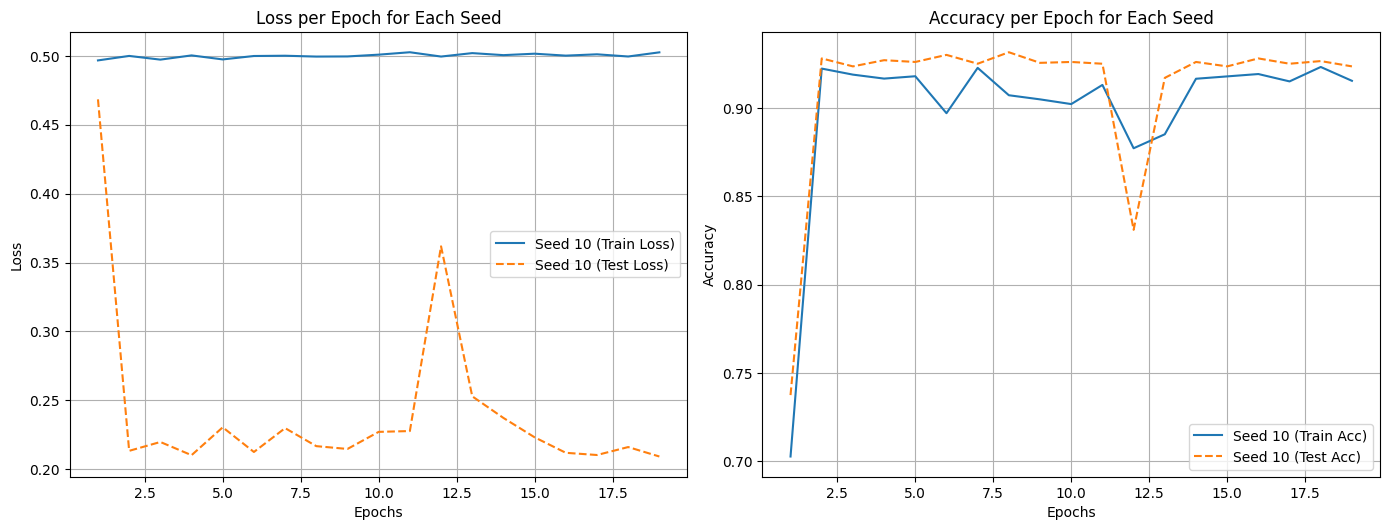

In [12]:
# Store the losses for the seed
# Plotting losses and accuracies for each seed
epochs = range(1, 20)  # Number of epochs
plt.figure(figsize=(14, 10))

# Loss plot
plt.subplot(2, 2, 1)
for i, losses in enumerate(all_losses):
    plt.plot(epochs, losses, label=f'Seed {seeds[i]} (Train Loss)')
for i, val_losses in enumerate(all_val_losses):
    plt.plot(epochs, val_losses, linestyle='--', label=f'Seed {seeds[i]} (Test Loss)')
plt.title('Loss per Epoch for Each Seed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Training accuracy plot
plt.subplot(2, 2, 2)
for i, train_acc in enumerate(all_train_acc):
    plt.plot(epochs, train_acc, label=f'Train Acc)')
for i, val_acc in enumerate(all_val_acc):
    plt.plot(epochs, val_acc, linestyle='--', label=f'(Val Acc)')
plt.title('Accuracy per Epoch for Each Seed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()    
